# **Variance Risk Premium Harvesting**

The **Variance Risk Premium (VRP)** is the persistent gap between **implied volatility (IV)** – the market’s price for future variance – and **realized volatility (RV)** – the variance that actually occurs.
Across years of data, IV tends to exceed RV because option sellers demand compensation for tail risk, crash hedging flows, and balance-sheet usage.

## **Why not blindly harvesting it?**

Blindly shorting volatility to collect this premium, however, is a recipe for large, clustered drawdowns in stress regimes. Our goal in this notebook is not to sell vol all the time, but to **harvest VRP selectively**, with explicit regime detection, position sizing, and risk filters.

For that:

- We treat **VRP as the primary edge** and aim to be **short variance** mainly in regimes where historical evidence shows IV > future RV on average.  
- We use **simple regime signals** (e.g. IV percentile buckets) to decide *when* VRP harvesting is acceptable and how large the position should be.  
- We add **tail-risk filters** (e.g. extreme IV levels, inverted term structure, vol-of-vol shocks) to **deactivate or shrink** the strategy in environments where short vol historically blows up.

The objective is not to eliminate risk, but to **capture the structural VRP while avoiding the most dangerous states**, improving the **risk-adjusted** profile of short-volatility carry.

The notebook is structured as follows:

1. [Read daily SPX Options chain & intraday SPX Index](#read_data)
2. [The Variance Risk Premium (VRP) — Stylized Facts](#vrp)
3. [Implementation Choice – How We Harvest VRP]()
4. [Baseline Strategy Prototype]()
5. [Trading Filters – Regimes & Tail-Risk Filters ]()
6. [Risk Management Overlay]()
7. [Simple Regime-Based Position Sizing]()
8. [Robustness/Reality & Regime Checks]()
9. [Final Evaluation Window ("True OOS")]()
10. [Conclusion](#plot_iv)  

In [4]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf

import volatility_trading.strategies.vrp_harvesting.plotting as ph
import volatility_trading.rv_forecasting.vol_estimators as rvvol

from volatility_trading.rv_forecasting.data_loading import load_intraday_prices
from volatility_trading.options.greeks import bs_greeks, bs_price

from volatility_trading.config.paths import INTER_OPTIONSDX, PROC_OPTIONSDX

np.random.seed(42)

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

# **1. Read SPX Options Data**

In this notebook we are going to consider the entire options chain, namely all strikes and expiries.
We use a reserach period from `2010` to `2020` for the development process to validate the startegy and we will latter on import data from 
`2021` to `2023` for the Really Out-of-Sample test.

In [5]:
start = "2010-01-01"
end = "2020-12-31"

In [6]:
file = INTER_OPTIONSDX / "full_spx_options_2010_2020.parquet"

cols = [
    "strike", "underlying_last", 
    "dte", "expiry",
    "c_delta", "p_delta", 
    "c_gamma", "p_gamma",
    "c_vega", "p_vega",
    "c_theta", "p_theta",
    "c_iv", "p_iv",
    "c_last", "p_last",
    "c_volume", "p_volume",
    "c_bid", "c_ask",
    "p_bid", "p_ask"
]

options = pd.read_parquet(file, columns=cols)
spot = options.groupby("date")["underlying_last"].first()

options["T"] = options["dte"] / 365
options["k"] = np.log(options["strike"] / options["underlying_last"])
options

,strike,underlying_last,dte,expiry,c_delta,p_delta,c_gamma,p_gamma,c_vega,p_vega,...,c_last,p_last,c_volume,p_volume,c_bid,c_ask,p_bid,p_ask,T,k
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,925.0,1132.99,3.0,2010-01-07,1.00000,-0.00077,0.00000,0.00004,0.00000,0.00439,...,0.00,0.05,0.0,550.0,205.99,208.99,0.00,0.06,0.008219,-0.202822
2010-01-04,950.0,1132.99,3.0,2010-01-07,1.00000,-0.00203,0.00000,0.00006,0.00000,0.00911,...,0.00,0.05,0.0,0.0,181.00,184.00,0.00,0.10,0.008219,-0.176153
2010-01-04,975.0,1132.99,3.0,2010-01-07,1.00000,-0.00369,0.00000,0.00022,0.00000,0.01302,...,0.00,0.10,0.0,0.0,156.00,159.00,0.05,0.10,0.008219,-0.150178
2010-01-04,1000.0,1132.99,3.0,2010-01-07,1.00000,-0.00894,0.00000,0.00038,0.00000,0.02786,...,0.00,0.15,0.0,0.0,131.10,134.10,0.15,0.21,0.008219,-0.124860
2010-01-04,1025.0,1132.99,3.0,2010-01-07,1.00000,-0.01251,0.00000,0.00066,0.00000,0.03857,...,0.00,0.20,0.0,720.0,106.21,109.20,0.20,0.25,0.008219,-0.100168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31,6100.0,3756.31,1079.0,2023-12-15,0.04870,-0.97152,0.00009,0.00000,6.58829,0.00000,...,0.00,0.00,0.0,0.0,10.00,30.00,2375.50,2447.50,2.956164,0.484852
2020-12-31,6200.0,3756.31,1079.0,2023-12-15,0.04492,-0.97169,0.00006,0.00000,6.16109,0.00000,...,0.00,0.00,0.0,0.0,8.30,28.30,2471.00,2542.99,2.956164,0.501112
2020-12-31,6300.0,3756.31,1079.0,2023-12-15,0.04203,-0.97145,0.00008,0.00000,5.77158,0.00000,...,0.00,2636.86,0.0,2.0,6.80,26.80,2568.00,2639.99,2.956164,0.517113


# **2. Variance Risk Premium (VRP) – Stylised Facts**

In index options, **implied volatility (IV)** tends to exceed the **realised volatility (RV)** that later materialises.  
The difference is the **Variance Risk Premium (VRP)**:

$$
\text{VRP} = \text{IV} - \text{RV}
$$

(In this notebook we measure VRP in *volatility* units at a fixed 21–30D horizon.)

Empirically, a positive VRP is observed across many maturities (strongest around short-dated 9–30D options) and across asset classes (equities, commodities, FX, single stocks).  

Understanding these stylised facts is crucial for volatility strategies:

- For **long vol**, VRP is the “hurdle rate” you must overcome to break even.  
- For **short vol**, it is the structural premium that can be harvested systematically—provided regime and tail risks are controlled.

### **Extract the 30-Days At-The-Money Implied Volatility**

In [4]:
iv_atm = pd.read_csv(DATA_PROC / "spx_atm_iv_30d_2010_2020.csv", index_col=0, parse_dates=True)
iv_atm *= 100

### **Extract CBOE VIX**

In [5]:
vix = yf.download('^VIX', start=start, end=end)["Close"]
vix = vix.rename(columns={"^VIX": "VIX"})
vix = vix["VIX"].squeeze()

/var/folders/4c/lbq7ysyx5zl93htfdcbr02br0000gn/T/ipykernel_3890/2335409478.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download('^VIX', start=start, end=end)["Close"]
[*********************100%***********************]  1 of 1 completed


### **Compute the 21-Day Realized Volatility**

We calculate **realized volatility** over a rolling **21-trading-day** window (which is approx 30 calendar days) represents the actual volatility observed over the past month. We prefer using the SP500 intraday 5min returns which is more efficient than daily close-to-close.

In [6]:
H = 21

es_5min = load_intraday_prices(DATA_INTER / "es-5m.csv", start=start, end=end)

# Compute the daily realized variance 
daily_rv = rvvol.rv_intraday(es_5min["close"])

# Compute the 21-D annualized realized volalitiy
rv_lag = (
    (np.sqrt(daily_rv.rolling(H).mean() * 252)) * 100
).rename("rv_lag")

rv = rv_lag.shift(-H).rename("rv")

In [7]:
vol_df = pd.concat([iv_atm, vix, rv, rv_lag], axis=1).dropna()

### **Compute the Variance Risk Prenium (VRP)**

In [8]:
vol_df["vrp"] = vol_df["iv_atm"] - vol_df["rv"]

## **2.1 Stylized facts 1: Positive VRP & Time varying**

The VRP is not constent, it eveolevs over time, however it is broadly positive.

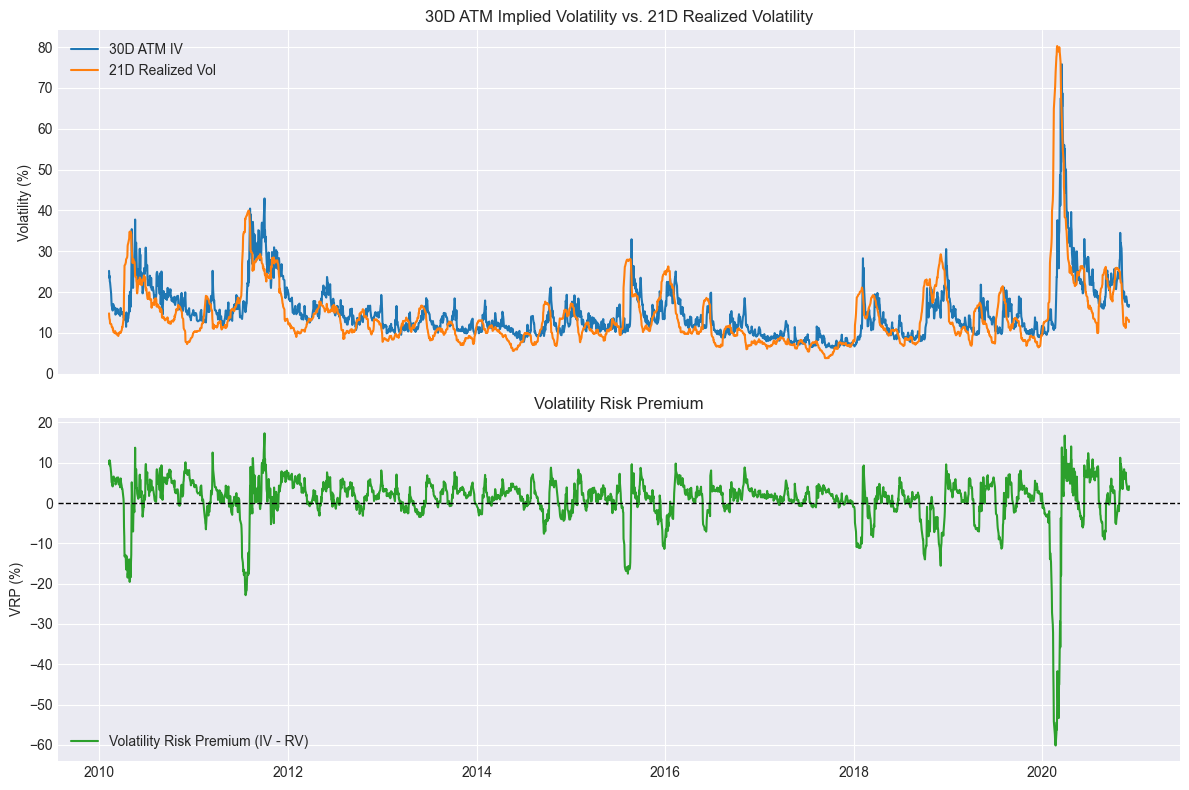

In [9]:
ph.plot_vrp(vol_df["iv_atm"], vol_df["rv"], vol_df["vrp"])

During calm markets, the VRP is typically positive, whereas during crashes (e.g., the COVID-19 lockdown) realized volatility can exceed implied volatility when the market fails to anticipate the shock. It migth sugguest that a strategy consiting in selling preniums can be profitabel over the long run. 

## **Stylized facts 3: VRP has fat-tails and skewed distribution**

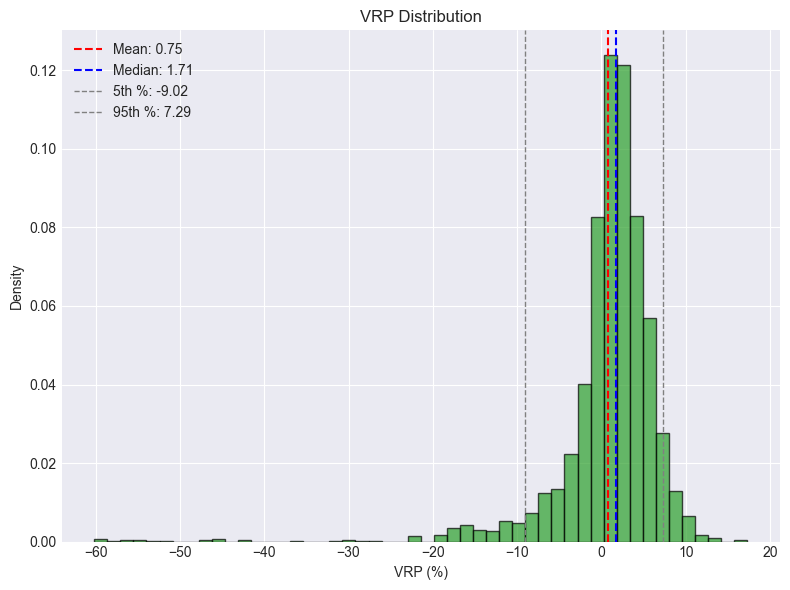

In [10]:
ph.plot_vrp_hist(vol_df["vrp"])

As you can see the VRP is positive in average but the presence how large left tails make its mean much less tha its median.
Thus excessive care msut be given to short vol strategies as they might be mostly mostly proftable but large blow ups can erode all prfoits accumulated over the years.
Thus the use of tail-risk filters like VIX Terme STructure, VVIX are essential to not avoid those large losess to materiazliee.

## **Stylised Fact 4 – VRP is Regime-Dependent**

The distribution of the Variance Risk Premium is **not stationary**.  
It shifts dramatically across volatility regimes:

- In **calm / low-volatility regimes**, VRP is usually positive and stable.  
- In **moderate / elevated volatility**, VRP often becomes larger (IV rises faster than RV).  
- In **stress / panic regimes**, VRP can remain **negative for extended periods**, and short-vol strategies become unprofitable.

This regime dependence is one of the key motivations for using **filters** and **regime-based sizing** in a VRP strategy.

In [11]:
bins = [-np.inf, 15, 20, 30, np.inf]

labels = [
    "15 <= VIX",
    "15 < VIX <= 20",
    "20 < VIX <= 30",
    "VIX >= 30",
]

vol_df["vix_bucket"] = pd.cut(vol_df["VIX"], bins=bins, labels=labels)

grouped = vol_df.groupby("vix_bucket", observed=True)["vrp"].agg(
    ["mean", "std", "max", "min", "skew", "count"]
)
grouped

,mean,std,max,min,skew,count
vix_bucket,,,,,,
15 <= VIX,-0.018500,5.009336,5.902433,-59.098562,-5.778822,1173
15 < VIX <= 20,0.902213,6.120893,8.757357,-60.168488,-3.823167,842
20 < VIX <= 30,1.690643,7.096890,12.531410,-56.983512,-3.745067,502
VIX >= 30,2.401942,11.979656,17.310865,-53.347527,-3.104832,184


On the full `2010–2020` sample, the typical size of the VRP and its variability both increase with VIX. 

- Extremely low-volatility regimes (VIX < 15) offer almost no premium.
- Intermediate regimes (20 < VIX ≤ 30) show the best risk–reward (high mean VRP relative to its dispersion). 
- Very high VIX(≥ 30) offers the richest VRP on average, but with much higher volatility and tail risk.

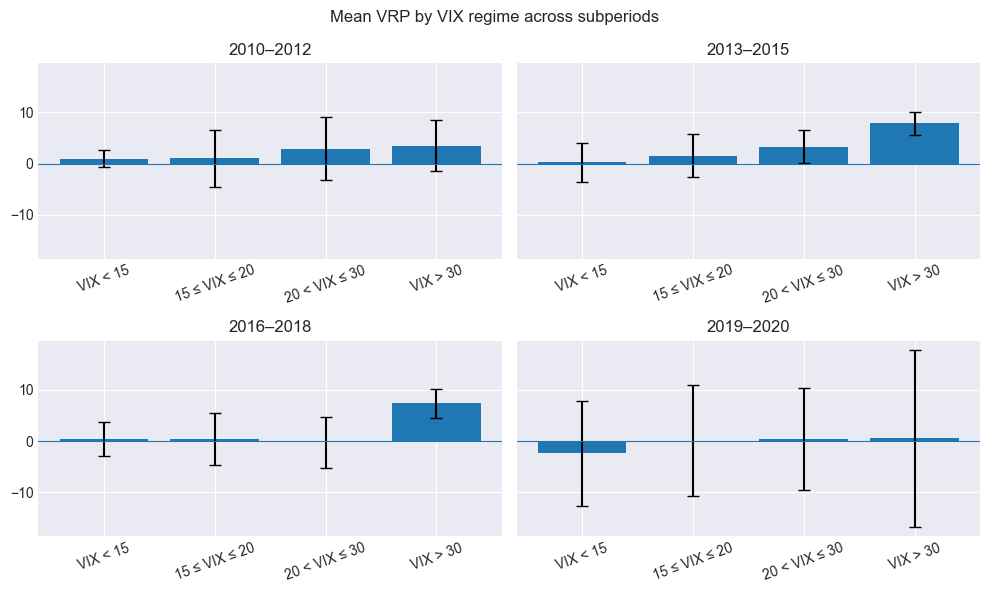

In [12]:
ph.plot_vrp_by_vix_bucket_subperiods(vol_df)

However, the subperiod breakdown shows that these bucket-level averages are
not stable over time:

- `2010–2015`: VRP is positive in most VIX regimes and increases with VIX.
- `2016–2018`: low-VIX buckets are close to flat; only VIX > 30 shows a strong
  positive premium.
- `2019–2020`: low-VIX regimes become outright negative, and even higher-VIX
  buckets show small means with very large dispersion.

In other words, the relation between VIX level and VRP has **shifted over
time**. The unconditional statistics hide this change. 

# **3. Implementation Choice – How We Harvest VRP**

There are several ways to sell volatility and capture the VRP:

- Short SPX options (straddles, strangles, butterflies, condors)
- Variance swaps
- VIX futures / short–vol ETPs

In this project we focus on **SPX options**, using simple 30-day structures that map cleanly to the
30D VRP we measure. We distinguish:

- **ATM Straddle (pure vol exposure)**  

  $$
  \Pi_{\text{straddle}}^{\text{long}} = C(K_0) + P(K_0)
  $$

  The **long** straddle is a classic long-volatility payoff: it profits from large moves of $S_T$
  away from the strike ($K_0 = S_0$). 
  When we **short** this structure (optionally delta-hedged in the
  backtest), we obtain clean exposure to realised variance, but with **unlimited downside**.

- **Iron Butterfly (straddle + OTM wings)**  

  $$
    \Pi_{\text{iron fly}}^{\text{long}}
    = C(K_0) + P(K_0) - \bigl(C(K_2) + P(K_1)\bigr),
  $$

  with strikes
  $$
  K_1 = S_0 - \Delta K,\quad
  K_0 = S_0,\quad
  K_2 = S_0 + \Delta K.
  $$

  To cap tail risk when shorting straddles or redecuign the prenium to be aid upfront when long straddles, we can add OTM “wings”. A convenient long iron butterfly
  payoff can be written as:

In the remainder of the notebook, “short straddle” and “short iron butterfly” will denote taking
the **short side** of these long payoffs, i.e. receiving the option premium and being short volatility.

In [13]:
# -------------------
# Configuration
# -------------------

S0 = 100.0         # spot
K0 = 100.0         # ATM strike
dK = 10.0          # wing distance for iron fly
K1 = K0 - dK       # lower wing
K2 = K0 + dK       # upper wing

T = 30 / 252       # 30 trading days to expiry
r = 0.02           # risk-free rate
q = 0.01           # dividend yield
sigma = 0.20       # implied vol (20%)

## **3.1 Payoff at maturity**

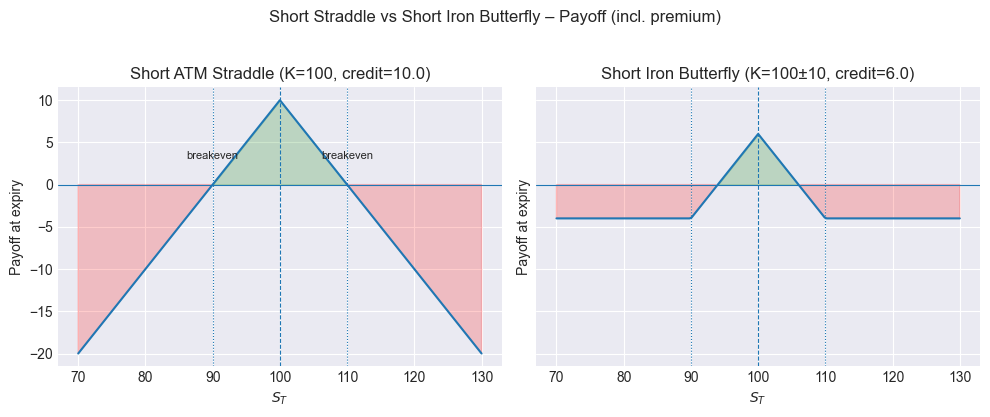

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

ph.plot_short_straddle_payoff(K=K0, net_premium=10.0, ax=axes[0])
ph.plot_short_iron_butterfly_payoff(K=K0, dK=dK, net_premium=6.0, ax=axes[1])

fig.suptitle("Short Straddle vs Short Iron Butterfly – Payoff (incl. premium)", y=1.03)
plt.tight_layout()
plt.show()

## **3.2 Greek profiles**

In [15]:
# ATM call/put at K0
gC0 = bs_greeks(S0, K0, T, sigma, r, q, option_type="call")
gP0 = bs_greeks(S0, K0, T, sigma, r, q, option_type="put")

# Wings for iron fly: call at K2, put at K1 (LONG in the long iron fly)
gC2 = bs_greeks(S0, K2, T, sigma, r, q, option_type="call")
gP1 = bs_greeks(S0, K1, T, sigma, r, q, option_type="put")

# -----------------------------
# 1) Short ATM straddle
# -----------------------------

delta_straddle = - (gC0["delta"] + gP0["delta"])
gamma_straddle = - (gC0["gamma"] + gP0["gamma"])
vega_straddle  = - (gC0["vega"]  + gP0["vega"])
theta_straddle = - (gC0["theta"] + gP0["theta"])

# -----------------------------
# 2) Short iron butterfly
# -----------------------------

delta_iron = - (gC0["delta"] + gP0["delta"] - gC2["delta"] - gP1["delta"])
gamma_iron = - (gC0["gamma"] + gP0["gamma"] - gC2["gamma"] - gP1["gamma"])
vega_iron  = - (gC0["vega"]  + gP0["vega"]  - gC2["vega"]  - gP1["vega"])
theta_iron = - (gC0["theta"] + gP0["theta"] - gC2["theta"] - gP1["theta"])

greeks = pd.DataFrame({
        "Delta": [delta_straddle, delta_iron],
        "Gamma": [gamma_straddle, gamma_iron],
        "Vega":  [vega_straddle,  vega_iron],
        "Theta": [theta_straddle, theta_iron],
    },
    index=["Short straddle", "Short iron fly"],
)

greeks

,Delta,Gamma,Vega,Theta
Short straddle,-0.041227,-0.115332,-27.460077,22.997775
Short iron fly,-0.006630,-0.074858,-17.823418,14.877576


A short straddle has higher (in absolute value) gamma, vega and theta exposure compared to a short iron fly.
This makes sense because the iron fly includes long wings (long OTM call and put) that add positive gamma and vega, and negative theta, which partially offset the Greeks of the short at-the-money options.

In addition you can see that there is some residual delta, whihc is usually hedged when it becomes significant (e.g $ |\Delta| > 0.1$)

## **3.3 P&L Distribution**

To build intuition about the risk/return trade-off, we compare the **P&L distributions**
of a short ATM straddle and a short iron butterfly in a simple toy model.

We assume the SPX follows a **Geometric Brownian Motion (GBM)** under a risk-neutral
measure and:

- price both structures at $t=0$ using Black–Scholes,
- simulate many terminal prices $S_T$,
- compute the **P&L of the short structures at expiry** (premium received minus payoff).

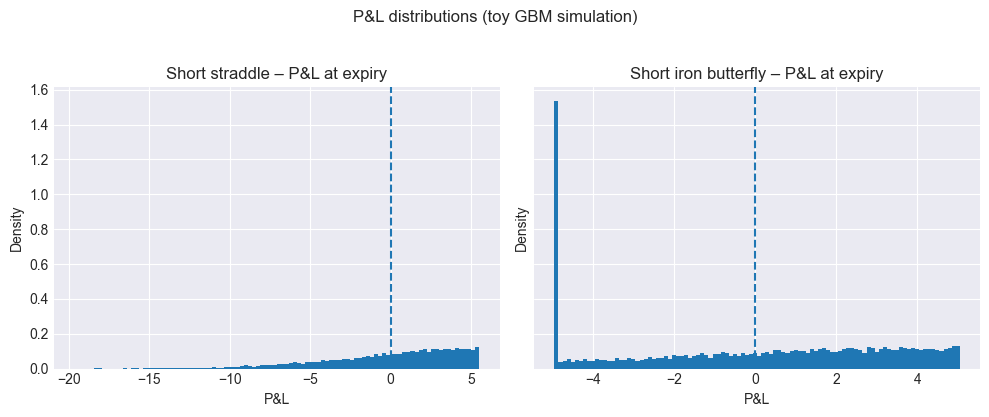

Short straddle: mean P&L = 0.019 , 5% quantile = -7.966
Short iron fly: mean P&L = 0.009 , 5% quantile = -4.952


In [16]:
np.random.seed(1234)
dec = 3
n_paths = 10_000  # MC paths
r = q = 0.00     # no drift

# --- 1) Price structures at t=0 (net premium for shorts) ---

# Short straddle = short call(K0) + short put(K0)
price_call_K0 = bs_price(S0, K0, T, sigma, r, q, option_type="call")
price_put_K0  = bs_price(S0, K0, T, sigma, r, q, option_type="put")
premium_straddle_short = price_call_K0 + price_put_K0  # credit received

# Long iron fly payoff: +C(K0)+P(K0) - C(K2) - P(K1)
price_call_K2 = bs_price(S0, K2, T, sigma, r, q, option_type="call")
price_put_K1  = bs_price(S0, K1, T, sigma, r, q, option_type="put")
premium_iron_short = price_call_K0 + price_put_K0 - price_call_K2 - price_put_K1

# --- 2) Simulate terminal prices under GBM ---

z = np.random.randn(n_paths)
S_T = S0 * np.exp((r - q - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * z)

# --- 3) Compute payoff at expiry ---

# Straddle intrinsic payoff (long)
payoff_straddle_long = np.abs(S_T - K0)
# Short straddle P&L at expiry
pnl_straddle_short = premium_straddle_short - payoff_straddle_long

# Iron fly intrinsic payoff (long iron fly)
call_K0_payoff = np.maximum(S_T - K0, 0.0)
put_K0_payoff  = np.maximum(K0 - S_T, 0.0)
call_K2_payoff = np.maximum(S_T - K2, 0.0)
put_K1_payoff  = np.maximum(K1 - S_T, 0.0)

payoff_iron_long = call_K0_payoff + put_K0_payoff - call_K2_payoff - put_K1_payoff

# Short iron fly P&L at expiry
pnl_iron_short = premium_iron_short - payoff_iron_long

# --- 4) Plot P&L distributions ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

ph.plot_pnl_hist(pnl_straddle_short,
    ax=axes[0],
    title="Short straddle – P&L at expiry",
)
ph.plot_pnl_hist(
    pnl_iron_short,
    ax=axes[1],
    title="Short iron butterfly – P&L at expiry",
)

fig.suptitle("P&L distributions (toy GBM simulation)", y=1.03)
plt.tight_layout()
plt.show()

print("Short straddle: mean P&L =", round(np.mean(pnl_straddle_short), dec),
      ", 5% quantile =", round(np.quantile(pnl_straddle_short, 0.05), dec))
print("Short iron fly: mean P&L =", round(np.mean(pnl_iron_short), dec),
      ", 5% quantile =", round(np.quantile(pnl_iron_short, 0.05), dec))

The short straddle collects more premium than the short iron fly, but at the cost of much **larger tail losses**.
In more realistic dynamics with **stochastic volatility and jumps**, these large loss scenarios would occur **more frequently**, making the naked short straddle significantly more fragile than the hedged structure.

# **4. Baseline Strategy Prototype**

**Objective:** Build the simplest possible strategy that harvests VRP, with minimal parameters.

- Fix a simple trading rule:
  - Structure: e.g. short ATM index options / short variance swap proxy.
  - Tenor: e.g. target 30D maturity, rolled mechanically.
  - No dynamic sizing: 1 “unit” of short vol when conditions allow.
- Simulate P&L over time with:
  - Realistic transaction costs & bid–ask assumptions
  - Simple margin / leverage constraints
- Evaluate:
  - Annualised return, vol, Sharpe / Sortino
  - Max drawdown and recovery time
  - Behaviour across subperiods and regimes (pre/post-crisis, low/high IV).

This becomes the **baseline** that all later variants are compared against.


In [17]:
from volatility_trading.options.io import reshape_options_wide_to_long

options = reshape_options_wide_to_long(options)

In [27]:
from volatility_trading.signals import ShortOnlySignal
from volatility_trading.strategies import VRPHarvestingStrategy
from volatility_trading.backtesting import BacktestConfig, to_daily_mtm
from volatility_trading.backtesting.engine import Backtester
from volatility_trading.backtesting.plotting import print_perf_metrics, plot_full_performance

sig = ShortOnlySignal()
strat = VRPHarvestingStrategy(signal=sig, holding_period=10)
cfg = BacktestConfig(initial_capital=100000, commission_per_leg=0.0)

options_red = options.loc["2010":"2016"]
data = {
    "options": options_red,
    "features": None,
    "hedge": None
}

In [28]:
bt = Backtester(data=data, strategy=strat, config=cfg)
trades, mtm = bt.run()
daily_mtm = to_daily_mtm(mtm, cfg.initial_capital)

In [ ]:
daily_mtm = to_daily_mtm(mtm, cfg.initial_capital)

🔍 Overall Performance Metrics
Sharpe Ratio           : 0.48
CAGR                   : -24.51%
Average Drawdown       : -30.46%
Max Drawdown           : -82.54%
Max Drawdown Duration  : 348 days
Historical VaR (99%)   : -13.37%
Historical CVaR (99%)  : -34.55%
Total P&L              : $-24,263.00
Profit Factor          : 0.60
Trade Frequency (ann.) : 34.4 trades/year
Total Trades           : 34
Win Rate               : 47.06%
Average Win P&L        : $3,367.19
Average Loss P&L       : $-4,960.00

📊 Performance by Contract Size
           win_rate  num_trades  total_win_pnl  total_loss_pnl  total_pnl
contracts                                                                
1              0.47          34        53875.0        -89280.0   -35405.0



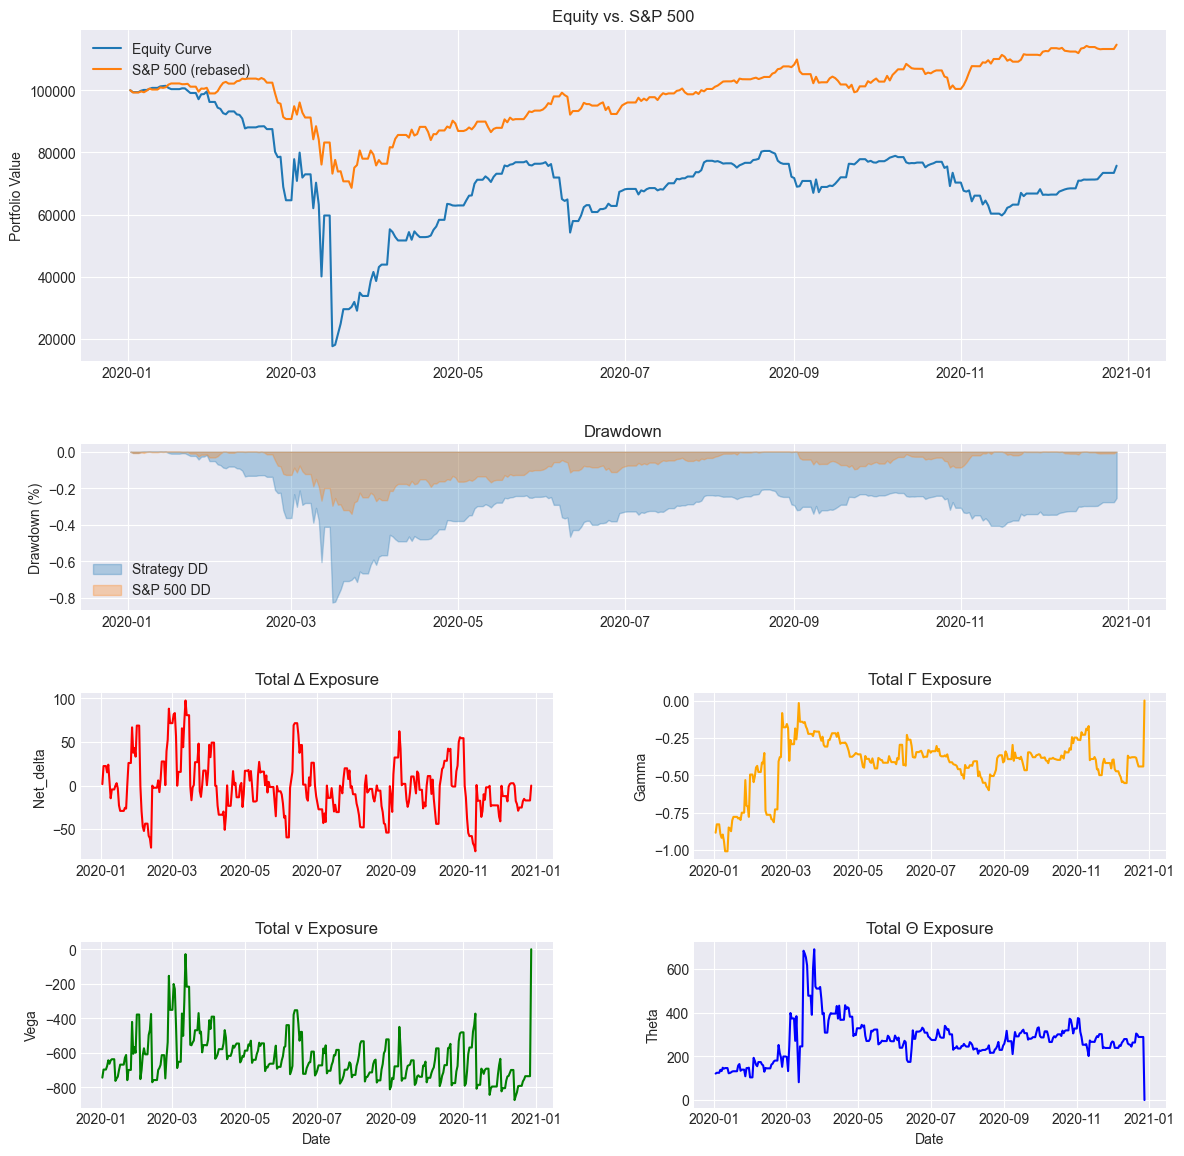

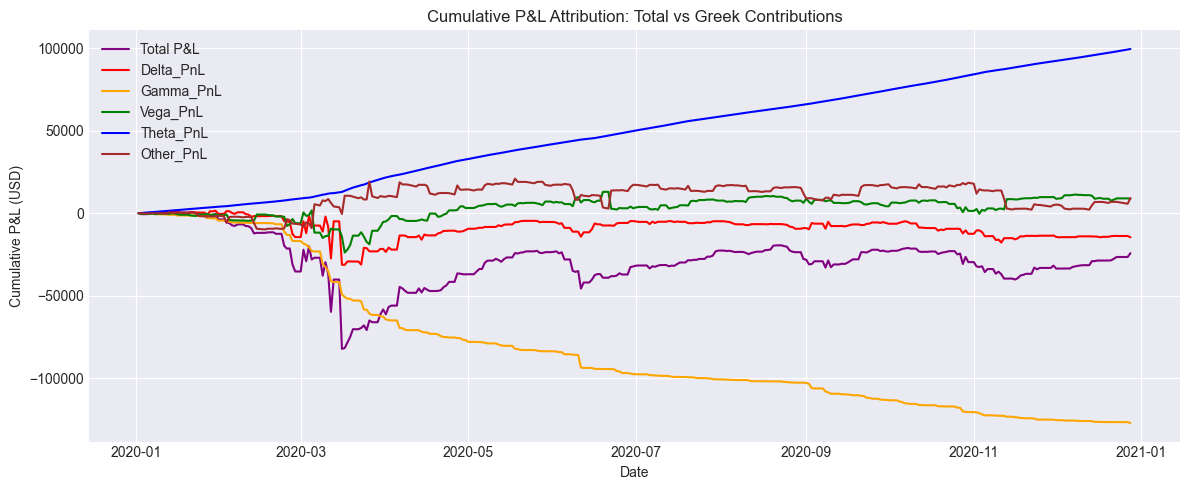

In [ ]:
from volatility_trading.backtesting.plotting import print_perf_metrics, plot_full_performance, plot_pnl_attribution
sp500 = options["underlying_last"].groupby("date").first()
print_perf_metrics(trades, daily_mtm)
plot_full_performance(sp500, daily_mtm)
plot_pnl_attribution(daily_mtm)